In [1]:
import dask
import pystac_client
import planetary_computer
import leafmap
import geogif
import stackstac
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from avgNdwi import main
from scipy.stats import gaussian_kde

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 13.65 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36167,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 13.65 GiB
Comm: tcp://127.0.0.1:45517,Total threads: 2
Dashboard: http://127.0.0.1:43097/status,Memory: 3.41 GiB
Nanny: tcp://127.0.0.1:36641,


In [3]:
bbox = (-71.882047, 42.0215975, -71.72, 42.299624)
start = ['2023-01-01']
end = ['2024-01-01']
year = 2023

In [4]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,)
search = catalog.search(
    collections = ['landsat-c2-l2'],
    bbox = bbox,
    query=["eo:cloud_cover<5"],
    datetime = start[0] + "/" + end[0]
)
items = search.get_all_items()
len(items)
print(items[2])
for item in items:
    print(item.assets.keys())
    break

<Item id=LC09_L2SP_012031_20231013_02_T1>
dict_keys(['qa', 'ang', 'red', 'blue', 'drad', 'emis', 'emsd', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'lwir11', 'swir16', 'swir22', 'coastal', 'mtl.txt', 'mtl.xml', 'mtl.json', 'qa_pixel', 'qa_radsat', 'qa_aerosol', 'tilejson', 'rendered_preview'])


In [5]:
stack = stackstac.stack(items, assets=["swir16", "red", "lwir"], epsg = 4326, bounds_latlon=bbox)
#stack = stackstac.stack(items, assets=["nir08", "red", "lwir"], epsg = 4326, bounds_latlon=bbox)

In [6]:
B3 = stack.sel(band = "red")
B4 = stack.sel(band = "swir16")
LST = stack.sel(band = "lwir")
ndvi = (B4 - B3) / (B3 + B4)


springNdvi = B3.sel(time=slice(f"{year}-03-21", f"{year}-06-21"))
summerNdvi = B3.sel(time=slice(f"{year}-06-21", f"{year}-09-23"))
fallNdvi = B3.sel(time=slice(f"{year}-09-23", f"{year}-12-22"))
winterNdvi1 = B3.sel(time=slice(f"{year}-12-22", f"{year}-12-31"))
winterNdvi2 = B3.sel(time=slice(f"{year}-01-01", f"{year}-03-20"))
winterNdvi1 = B3.sel(time=slice(f"{year}-12-22", f"{year}-12-31"))

avgNdvi = ndvi.mean(dim=["time"],skipna=True)
avgLst = LST.mean(dim=["time"],skipna=True)
avgLst = avgLst - 273.15

print(len(ndvi))
print(len(springNdvi))
print(len(fallNdvi))
print(len(winterNdvi1))
print(len(winterNdvi2))
print(len(summerNdvi))

21
9
7
0
1
4


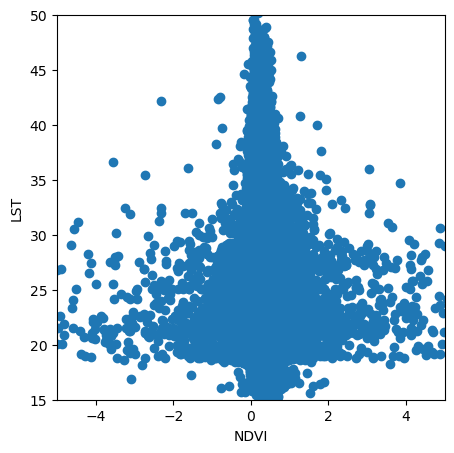

In [7]:
plt.rcParams['figure.figsize'] = (12,8)
plt.figure(figsize = (5, 5))
plt.scatter(x=avgNdvi, y=avgLst)
plt.xlabel("NDVI")
plt.ylabel("LST")
plt.ylim(15,50)
plt.xlim(-5,5)
plt.show()

In [152]:
def removeExtraneous(ndvi):
    reducedNdvi = ndvi.where((ndvi >= -1) & (ndvi <= 1))
    return reducedNdvi

In [153]:
reducedSpringNdvi = removeExtraneous(springAvgNdvi)
reducedSummerNdvi = removeExtraneous(summerAvgNdvi)
print(len(reducedSpringNdvi))
print(len(summerNdvi))

1021
4


In [125]:
def average(dataArray):
    avgArray = dataArray.mean(dim=["time"], skipna=True)
    return avgArray

In [126]:
springAvgNdvi = average(springNdvi)
summerAvgNdvi = average(summerNdvi)

In [158]:
# avgNdvi.plot()

# normalized_avgNdvi = springNdvi
# normalized_avgNdvi = normalized_avgNdvi.where((normalized_avgNdvi >= -1) & (normalized_avgNdvi <= 1))
# avgNdvi = normalized_avgNdvi
#springAvgNdvi.plot(cmap='RdYlGn')
#avgNdvi.plot(cmap='RdYlGn')

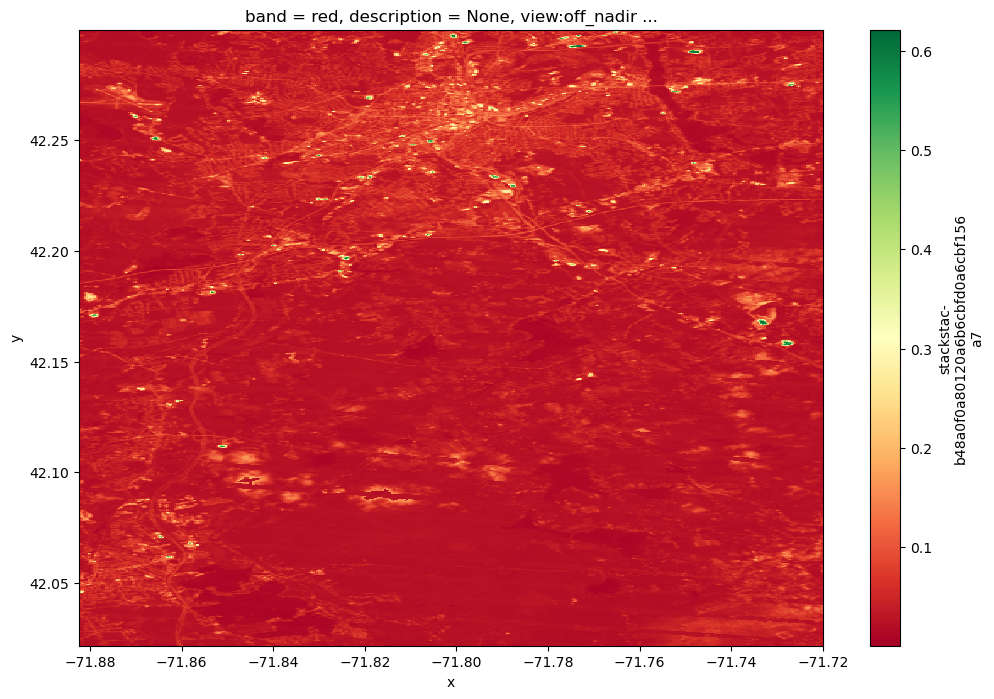

In [119]:
summerAvgNdvi.plot(cmap='RdYlGn')

In [46]:
avgLst_values = avgLst.values 
avgNdvi_values = avgNdvi.values 

# Remove NaN values from both avgLst and avgNdvi
valid_mask = ~np.isnan(avgLst_values) & ~np.isnan(avgNdvi_values)

# Apply the mask to both arrays
avgLst_valid = avgLst_values[valid_mask]
avgNdvi_valid = avgNdvi_values[valid_mask]

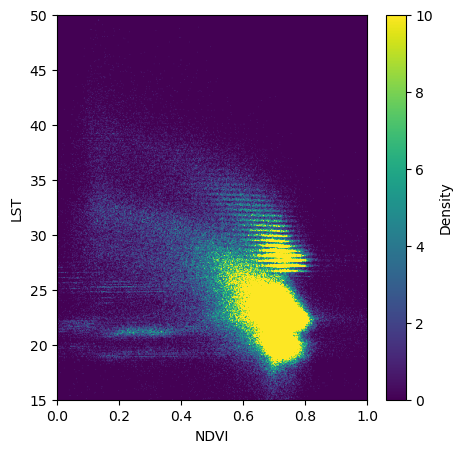

In [63]:
hist, xedges, yedges = np.histogram2d(avgNdvi_valid.flatten(), avgLst_valid.flatten(), bins=1000)

plt.figure(figsize=(5,5))
plt.imshow(
    hist.T, 
    origin='lower', 
    aspect='auto', 
    extent=[xedges.min(), xedges.max(), yedges.min(), yedges.max()],
    cmap='viridis',
    vmax=10
)
plt.colorbar(label='Density')
plt.xlabel("NDVI")
plt.ylabel("LST")
plt.ylim(15,50)
plt.xlim(0,1)
plt.show()

In [91]:
def createDensity(avgNdvi, avgLst):
    # Convert to numpy arrays
    avgLst = np.asarray(avgLst.values)
    avgNdvi = np.asarray(avgNdvi.values)

    # Create a valid mask
    valid_mask = ~np.isnan(avgLst) & ~np.isnan(avgNdvi)

    # Apply mask and flatten
    avgLst = avgLst[valid_mask].flatten()
    avgNdvi = avgNdvi[valid_mask].flatten()

    # Create histogram
    hist, xedges, yedges = np.histogram2d(avgNdvi, avgLst, bins=1000)

    # Plotting the density
    plt.figure(figsize=(5,5))
    plt.imshow(
        hist.T, 
        origin='lower', 
        aspect='auto', 
        extent=[xedges.min(), xedges.max(), yedges.min(), yedges.max()],
        cmap='viridis',
        vmax=1000
    )
    plt.colorbar(label='Density')
    plt.xlabel("NDVI")
    plt.ylabel("LST")
    plt.ylim(15,50)
    plt.xlim(0,1)
    plt.show()

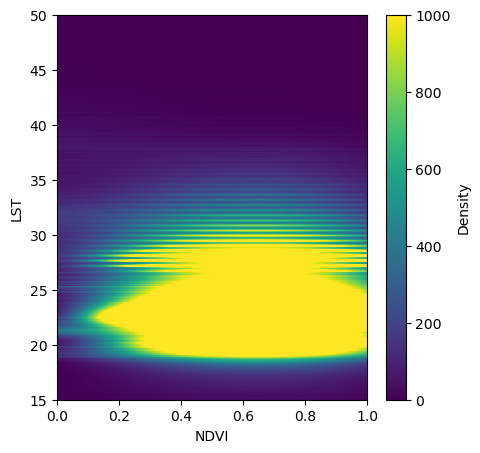

In [92]:
createDensity(avgNdvi, avgLst)